# Решение уравнения Навье-Сткоса в цилиндрических координатах с помощью нейронных сетей


In [117]:
import tensorflow as tf
import numpy as np

FLOAT_32 = 'float32'


# Определение классов

In [118]:
class PINN_Model(tf.keras.Model):
    def __init__(self,
                 t_boundaries,
                 z_boundaries,
                 output_dim=1,
                 num_hidden_layers=8,
                 num_neurons_per_layer=20,
                 activation='tanh',
                 kernel_initializer='glorot_normal',
                 **kwargs):
        super().__init__(**kwargs)

        self.t_lower_boundary = t_boundaries[0]
        self.t_upper_boundary = t_boundaries[1]

        self.z_lower_boundary = z_boundaries[0]
        self.z_upper_boundary = z_boundaries[1]

        self.output_dim = output_dim
        self.out = tf.keras.layers.Dense(output_dim)

        self.num_hidden_layers = num_hidden_layers
        self.hidden = [
            tf.keras.layers.Dense(
                units=num_neurons_per_layer,
                activation=tf.keras.activations.get(activation),
                kernel_initializer=kernel_initializer
            ) for _ in range(self.num_hidden_layers)]

    def call(self, X):
        Z = X
        for i in range(self.num_hidden_layers):
            Z = self.hidden[i](Z)
        return self.out(Z)


In [119]:
class Navier_Stokes_Cylinder_PINN_Solver:
    def __init__(self, model, X_r):
        self.model = model

        self.t = X_r[:, 0:1]
        self.z = X_r[:, 1:2]
        self.r = X_r[:, 2:3]
        self.phi = X_r[:, 3:4]

        self.losses = []

    def get_gradient_result(self):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.t)
            tape.watch(self.z)
            tape.watch(self.r)
            tape.watch(self.phi)

            u = self.model(tf.stack(
                [self.t[:, 0],
                 self.z[:, 0],
                 self.r[:, 0],
                 self.phi[:, 0]],
                axis=1))

            u_z = u[1]
            u_r = u[2]
            u_phi = u[3]

            u_z_dr = tape.gradient(u_z, self.r)
            u_z_d_phi = tape.gradient(u_z, self.phi)
            u_z_dt = tape.gradient(u_z, self.t)
            u_z_dz = tape.gradient(u_z, self.z)
            
            u_z_d_phi_2 = tape.gradient(u_z_d_phi, self.phi)
            d_u_z_dz_2 = tape.gradient(u_z_dz, self.z)

            r_u_z_dr_2 = tape.gradient(self.r * u_z_dr, self.r)

        del tape

        return self.func(u_r, u_phi, u_z,
                         u_z_dt, u_z_d_phi, u_z_dr, u_z_dz,
                         u_z_d_phi_2, d_u_z_dz_2,
                         r_u_z_dr_2)

    @staticmethod
    def func(u_r, u_phi, u_z,
             u_z_dt, u_z_d_phi, u_z_dr, u_z_dz,
             u_z_d_phi_2, d_u_z_dz_2,
             r_u_z_dr_2):
        rho = 1
        r = 1
        nu = 1
        dp_dz = 0

        return (rho * (u_z_dt + u_r * u_z_dr + u_phi / r * u_z_d_phi + u_z * u_z_dz) + dp_dz
                - nu * (1 / r * r_u_z_dr_2 + 1 / (r * r) * u_z_d_phi_2 + d_u_z_dz_2))

    def loss_function(self, X, u):
        result = self.get_gradient_result()
        loss = tf.reduce_mean(tf.square(result))

        for i in range(len(X)):
            u_predict = self.model(X[i])
            loss += tf.reduce_mean(tf.square(u[i] - u_predict))

        return loss

    def get_gradient_with_loss(self, X, u):
        with tf.GradientTape(persistent=True) as tape:
            tape.watch(self.model.trainable_variables)
            loss = self.loss_function(X, u)

        gradient = tape.gradient(loss, self.model.trainable_variables)

        del tape

        return loss, gradient

    def solve(self, optimizer, X, u, num_epochs=1001):

        @tf.function
        def train_step():
            loss, gradient = self.get_gradient_with_loss(X, u)
            optimizer.apply_gradients(zip(gradient, self.model.trainable_variables))
            return loss

        step = 0
        for i in range(num_epochs):
            current_loss = train_step().numpy()
            self.losses.append(current_loss)
            step += 1

            if step % 100 == 0:
                print('i = {:05d}: Ошибка = {:10.8e}'.format(step, current_loss))

    def plot_losses(self, ax=None):
        if not ax:
            fig = plt.figure(figsize=(7, 5))
            ax = fig.add_subplot(111)
        ax.semilogy(range(len(self.losses)), self.losses, 'k-')
        ax.set_xlabel('$n_{epoch}$')
        ax.set_ylabel('$\\phi^{n_{epoch}}$')
        return ax

# Начальное условие и граничное условие - в данном случае просто единичное условие

In [120]:
# начальное условие или граничное условие - в данном случае просто единичное условие
def fun_u_initial_and_boundary(t):
    n = t.shape[0]
    return tf.ones((n, 1), dtype=FLOAT_32)


# Инициализация данных

In [121]:
N = 50
N_r = 10000

t_min, t_max = 0., 1.
z_min, z_max = 0., 1.

t_boundaries = [t_min, t_max]
z_boundaries = [z_min, z_max]

tf.random.set_seed(0)

t_0 = tf.zeros((N, 1), dtype=FLOAT_32)
t_b = tf.random.uniform((N, 1), t_min, t_max, dtype=FLOAT_32)

z_0 = tf.random.uniform((N, 1), z_min, z_max, dtype=FLOAT_32)
z_b = z_min + (z_max - z_min) * tf.keras.backend.random_bernoulli((N, 1), 0.5, dtype=FLOAT_32)

u_z_0 = fun_u_initial_and_boundary(t_0)
u_z_b = fun_u_initial_and_boundary(t_b)

r = tf.ones((N, 1), dtype=FLOAT_32)
phi = tf.zeros((N, 1), dtype=FLOAT_32)

X_0 = tf.concat([t_0, z_0, r, phi], axis=1)
X_b = tf.concat([t_b, z_b, r, phi], axis=1)

t_r = tf.random.uniform((N_r, 1), t_min, t_max, dtype=FLOAT_32)
z_r = tf.random.uniform((N_r, 1), z_min, z_max, dtype=FLOAT_32)

r_r = tf.ones((N_r, 1), dtype=FLOAT_32)
phi_r = tf.zeros((N_r, 1), dtype=FLOAT_32)

X_r = tf.concat([t_r, z_r, r_r, phi_r], axis=1)

X_data = [X_0,
          X_b]

u_data = [u_z_0,
          u_z_b]

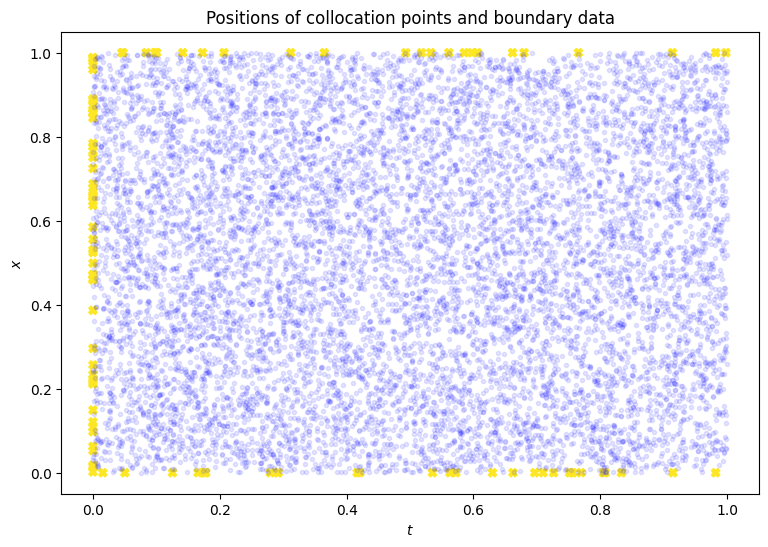

In [122]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9, 6))
plt.scatter(t_0, z_0, c=u_z_0, marker='X', vmin=-1, vmax=1)
plt.scatter(t_b, z_b, c=u_z_b, marker='X', vmin=-1, vmax=1)
plt.scatter(t_r, z_r, c='b', marker='.', alpha=0.1)
plt.xlabel('$t$')
plt.ylabel('$x$')

plt.title('Positions of collocation points and boundary data');

# Обучение модели

In [123]:
model = PINN_Model(t_boundaries, z_boundaries)
model.build(input_shape=(None, 4))

solver = Navier_Stokes_Cylinder_PINN_Solver(model, X_r)

In [124]:
learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 2000, 3000], [1e-1, 1e-2, 1e-3, 1e-4])
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

solver.solve(optimizer, X_data, u_data, num_epochs=5001)

i = 00100: Ошибка = 1.18445489e-04
i = 00200: Ошибка = 8.81545566e-05
i = 00300: Ошибка = 6.68195062e-05
i = 00400: Ошибка = 5.14052153e-05
i = 00500: Ошибка = 4.05507963e-05
i = 00600: Ошибка = 3.29483992e-05
i = 00700: Ошибка = 2.75826460e-05
i = 00800: Ошибка = 2.37118802e-05
i = 00900: Ошибка = 2.08172823e-05
i = 01000: Ошибка = 1.85548597e-05
i = 01100: Ошибка = 1.67066501e-05
i = 01200: Ошибка = 1.51404429e-05
i = 01300: Ошибка = 1.37763209e-05
i = 01400: Ошибка = 1.25637225e-05
i = 01500: Ошибка = 1.14717623e-05
i = 01600: Ошибка = 1.04781811e-05
i = 01700: Ошибка = 9.56843996e-06
i = 01800: Ошибка = 8.73197951e-06
i = 01900: Ошибка = 7.96223958e-06
i = 02000: Ошибка = 7.25291920e-06
i = 02100: Ошибка = 6.59971920e-06
i = 02200: Ошибка = 5.99900341e-06
i = 02300: Ошибка = 5.44696832e-06
i = 02400: Ошибка = 4.94113965e-06
i = 02500: Ошибка = 4.47782031e-06
i = 02600: Ошибка = 4.05468518e-06
i = 02700: Ошибка = 3.66865697e-06
i = 02800: Ошибка = 3.31730553e-06
i = 02900: Ошибка = 

<Axes: xlabel='$n_{epoch}$', ylabel='$\\phi^{n_{epoch}}$'>

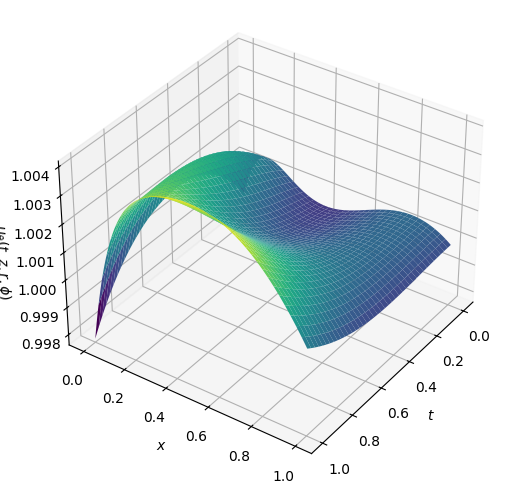

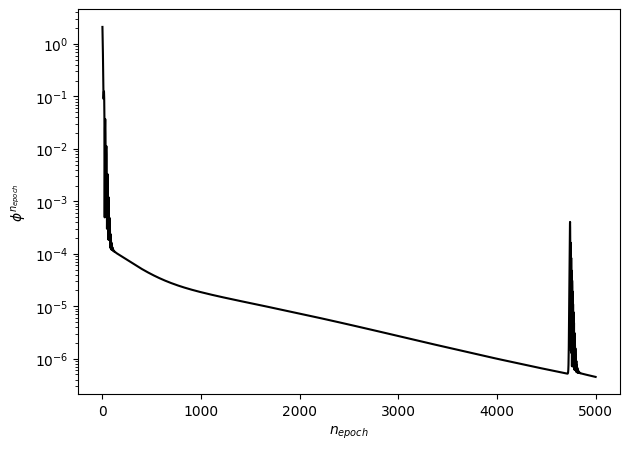

In [125]:
def plot_surface_solution(model, **kwargs):
    num_of_elements = 200

    t_space = np.linspace(model.t_lower_boundary, model.t_upper_boundary, num_of_elements + 1)
    x_space = np.linspace(model.z_lower_boundary, model.z_upper_boundary, num_of_elements + 1)

    T, X = np.meshgrid(t_space, x_space)
    meshgrid = np.vstack([T.flatten(), X.flatten()]).T

    flatten_size = len(T.flatten())
    r_space = tf.ones((flatten_size, 1))
    phi_space = tf.zeros((flatten_size, 1))

    X_data = tf.concat([meshgrid, r_space, phi_space], axis=1)
    u_predict = model(tf.cast(X_data, FLOAT_32))
    U = u_predict.numpy().reshape(num_of_elements + 1, num_of_elements + 1)

    fig = plt.figure(figsize=(9, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(T, X, U, cmap='viridis', **kwargs)
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.set_zlabel('$u_\\theta(t,z,r,\\phi)$')
    ax.view_init(35, 35)
    return ax


plot_surface_solution(model)
solver.plot_losses()